# 1. Introduction

Welcome to your fourth assignment. In this assignment, you will build a convolutional neural network step by step. In this notebook, you will implement all the functions required to build a convolutional neural network.

After finishing this assignment, you will have a deeper understanding of the process of training a convolutional neural network, which mainly consists of two parts: convolution layer and pooling layer.

# 2. Packages
All the packages that you need to finish basic part of this assignment are listed below.
*   numpy : The fundamental package for scientific computing with Python.
*   matplotlib : A comprehensive library for creating static, animated, and interactive visualizations in Python.
*   math : Python has a built-in module that you can use for mathematical tasks.
*   pandas.read_csv : Provides functionality for reading a csv dataset from a GitHub repository.
* sklearn.model_selection.train_test_split: A function helps you split train and test data.
* os: A module provides the facility to establish the interaction between the user and the operating system. You can access the image directory by os.
* cv2.imread: It is the module import name for opencv-python.
* time: Provides various time-related functions.
* google.colab.drive: Let you connect colab and your googol drive.
* sys: Let you access system-specific parameters and functions.

⚠️ **WARNING** ⚠️: 
*   Please do not import any other packages in basic part.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ### (≈ n lines)
...
### END CODE HERE ###
```



In [158]:
# from google.colab import drive
# drive.mount('/content/drive')

In [159]:
import sys
sys.path.append("./") ## the path of the directory where you place dense.py, activation.py ....

In [160]:
import os
import math
import time 
import numpy as np
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow you to load the image as gray scale image
from pandas import read_csv
import matplotlib.pyplot as plt

###### import your HW3 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_BCE_cost
from Predict import predict
##################################

output = {}
seed = 1
np.random.seed(seed)

# 3. Convolution layer

In this section, you will need to implement a very important part of the convolutional neural network, which is the convolution layer. Convolution layer enables us to capture the important features of input images.

You will have to implement two helper functions and the forward pass of the convolution layer. All you need to do is to follow the instructions and understand how each part works.

In [161]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C), where m represent the number of examples.
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    # GRADED FUNCTION: zero_padding
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0) ),'constant')
    ### END CODE HERE ###
    
    return X_pad


In [162]:
class Conv():
    def __init__(self, filter_size=2, input_channel=3, output_channel=8, pad=1, stride=1, seed=1):
        
        self.filter_size= filter_size
        self.input_channel=input_channel
        self.output_channel=output_channel
        self.seed = seed
        
        self.parameters = {"pad": pad, "stride": stride}
        self.initialize_parameters()
        
        
        self.name="conv"

    def initialize_parameters(self):
        """
        Argument:
        self.filter_size -- size of the filter
        self.input_channel -- size of the input channel
        self.output_channel -- size of the output channel
        self.parameters -- python dictionary containing your parameters:
                           W -- weight matrix of shape (filter_size, filter_size, input channel size, output channel size)
                           b -- bias vector of shape (1, 1, 1, output channel size)
                           pad -- amount of padding around each image on vertical and horizontal dimensions
                           stride -- represent the amount of movement that a filter move in one step
        """
        np.random.seed(seed)

        # GRADED FUNCTION: conv_initialization
        ### START CODE HERE ### (≈ 8 lines)
        limit = math.sqrt(6 / (self.input_channel + self.output_channel))
        W = np.random.uniform(-limit,limit,(self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        b = np.random.uniform(0,0,(1,1,1,self.output_channel))
        ### END CODE HERE ###

        assert(W.shape == (self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        assert(b.shape == (1,1,1,self.output_channel))

        self.parameters['W'] = W
        self.parameters['b'] = b
        
    
    
    def conv_single_step(self, a_slice_prev, W, b):
        """
        Apply a filter W on a_slice_prev.

        Arguments:
        a_slice_prev -- slice of input data of shape (filter_size, filter_size, n_C_prev)
        W -- Weight parameters contained in a window - matrix of shape (filter_size, filter_size, n_C_prev)
        b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

        Returns:
        Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
        """

        # GRADED FUNCTION: conv_single_step
        ### START CODE HERE ### (≈ 3 lines)
        # Element-wise product between a_slice and W.
        s = np.multiply(a_slice_prev, W)
        # Sum over all entries of the volume s.
        Z = np.sum(s)
        # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
        Z = Z + float(b)
        Z = np.sum(Z)
        ### END CODE HERE ###

        return Z
    
    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution layer

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
        """

        # GRADED FUNCTION: conv_forward
        ### START CODE HERE ###
        # Retrieve dimensions from A_prev's shape (≈1 line)  
        
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        
        # Retrieve dimensions from W's shape (≈1 line)
        (f, f, n_C_prev, n_C) = self.parameters["W"].shape
        
        
        # Compute the dimensions of the convolution output volume using the formula given below.(≈2 lines)
        n_H = (n_H_prev - f + 2 * self.parameters["pad"])//self.parameters["stride"] + 1
        n_W = (n_W_prev - f + 2 * self.parameters["pad"])//self.parameters["stride"] + 1

        # Initialize the output volume Z with zeros. (≈1 line)
        Z = np.zeros((m,n_H,n_W,n_C),dtype=float)

        # if pad!=0, create A_prev_pad by padding A_prev with the parameter "pad". (≈1 line)
        A_prev_pad = zero_pad(A_prev, self.parameters["pad"])

        for i in range(m):                               # loop over the batch of training examples
            a_prev_pad = A_prev_pad[i,:,:,:]               # Select ith training example's padded activation
            for h in range(n_H):                           # loop over vertical axis of the output volume
                for w in range(n_W):                       # loop over horizontal axis of the output volume
                    for c in range(n_C):                   # loop over channels (= #filter) of the output volume

                        # Find the corners of the current "slice" (≈4 lines)
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + f
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + f
                        
                        # Use the corners to define the slice of a_prev_pad. (≈1 line)
                        a_slice_prev = a_prev_pad[ vert_start:vert_end, horiz_start:horiz_end, :]

                        # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                        Z[i, h, w, c] = self.conv_single_step(a_slice_prev, self.parameters["W"][:,:,:,c], self.parameters["b"][:,:,:,c])

        ### END CODE HERE ###

        # Making sure your output shape is correct
        assert(Z.shape == (m, n_H, n_W, n_C))

        # Save information in "cache" for the backward pass
        self.cache = A_prev

        return Z
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution layer

        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)

        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        """


        A_prev = self.cache

        # Retrieve dimensions from A_prev's shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        
        # Retrieve dimensions from W's shape
        (f, f, n_C_prev, n_C) = self.parameters["W"].shape


        # Retrieve dimensions from dZ's shape
        (m, n_H, n_W, n_C) = dZ.shape

        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
        dW = np.zeros((f, f, n_C_prev, n_C))
        db = np.zeros((1, 1, 1, n_C))

        # Pad A_prev and dA_prev
        A_prev_pad = zero_pad(A_prev, self.parameters["pad"])
        dA_prev_pad = zero_pad(dA_prev, self.parameters["pad"])

        for i in range(m):                       # loop over the training examples

            # select ith training example from A_prev_pad and dA_prev_pad
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]

            for h in range(n_H):                   # loop over vertical axis of the output volume
                for w in range(n_W):               # loop over horizontal axis of the output volume
                    for c in range(n_C):           # loop over the channels of the output volume

                        # Find the corners of the current "slice"
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + f
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + f

                        # Use the corners to define the slice from a_prev_pad
                        a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                        # Update gradients for the window and the filter's parameters
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.parameters["W"][:,:,:,c] * dZ[i, h, w, c]
                        dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                        db[:,:,:,c] += dZ[i, h, w, c]

            # Set the ith training example's dA_prev to the unpaded da_prev_pad
            dA_prev[i, :, :, :] = da_prev_pad[self.parameters["pad"]:da_prev_pad.shape[0]-self.parameters["pad"], 
                                              self.parameters["pad"]:da_prev_pad.shape[1]-self.parameters["pad"], :]

        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

        self.dW = dW
        self.db = db

        return dA_prev
    
    def update(self, learning_rate):
        """
        Update parameters using gradient descent
        
        Arguments:
        learning rate -- step size
        """

        # GRADED FUNCTION: conv_update
        ### START CODE HERE ### (≈ 2 lines of code)
        self.parameters["W"] -= learning_rate * self.dW
        self.parameters["b"] -= learning_rate * self.db
        ### END CODE HERE ###


##3.1 initialization
Using Glorot uniform initialization to initialize the convolution layer's filters with the parameters: filter_size, input_channel, and output_channel.

*   Use random initialization (uniform distribution) for the weight matrices. Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)), fan_in is the **number of input channel** and fan_out is the **number of output channel**. However, in the usual implementation, we will consider fan_in and fan_out as the number of input units and the number of output units.
*   Use zero initialization for the biases.

Exercise: Create and initialize parameters of a convolution layer using Glorot uniform initialization. (1%)

It will take following parameters to initialize the convolution layer:
*   filter_size: The filter will be in the shape of (filter_size*filter_size)
*   input_channel: size of the input channel
*   output_channel: size of the output channel
*   pad: amount of padding around each image on vertical and horizontal dimensions
*   stride: represent the amount of movement that a filter move in one step

In [163]:
np.random.seed(seed)
conv = Conv(filter_size=2, input_channel=3, output_channel=8, pad=2, stride=2)
print("W[0][0][0] = ",  conv.parameters["W"][0][0][0])
print("b = ", conv.parameters["b"])

np.random.seed(seed)
conv = Conv(filter_size=2, input_channel=3, output_channel=16, pad=2, stride=2)
output["conv_initialization"] = conv.parameters["W"][0][0][0]

W[0][0][0] =  [-0.12256662  0.32544084 -0.73838    -0.29197414 -0.52177613 -0.6021558
 -0.46342438 -0.22812192]
b =  [[[[0. 0. 0. 0. 0. 0. 0. 0.]]]]


Expected output: 
<table>
  <tr>
    <td>W[0][0][0]: </td>
    <td>[-0.12256662  0.32544084 -0.73838    -0.29197414 -0.52177613 -0.6021558 -0.46342438 -0.22812192]</td>
  </tr>
  <tr>
    <td>b: </td>
    <td>[[[[0. 0. 0. 0. 0. 0. 0. 0.]]]]</td>
  </tr>
</table>

## 3.2  Zero-Padding

Pad around each image on vertical and horizontal dimensions with zero.

1. It allows you to use a convolution layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks since otherwise the height/width would shrink as you go to deeper layers. 
2. It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

**Exercise**: Implement the zero_pad() function to pad the input X with the given parameter "pad". (3%)

This function takes the following inputs:
*   X: input.
*   pad: amount of padding around each image on vertical and horizontal dimensions.

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[0,2,:,0] =
 [-0.3224172   1.13376944 -0.17242821]
x_pad[0,2,:,0] =
 [ 0.          0.          1.62434536 -0.52817175  0.86540763  0.
  0.        ]


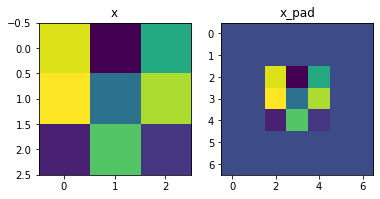

In [164]:
np.random.seed(seed)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[0,2,:,0] =\n", x[0,2,:,0])
print ("x_pad[0,2,:,0] =\n", x_pad[0,2,:,0])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

np.random.seed(seed)
x = np.random.randn(4, 2, 2, 2)
x_pad = zero_pad(x, 1)
output["zero_padding"] = x_pad[0,1,:,0]

Expected output: 
<table>
  <tr>
    <td>x.shape: </td>
    <td>(4, 3, 3, 2)</td>
  </tr>
  <tr>
    <td>x_pad.shape: </td>
    <td>(4, 7, 7, 2)</td>
  </tr>
  <tr>
    <td>x[0,2,:,0]: </td>
    <td>[-0.3224172   1.13376944 -0.17242821]</td>
  </tr>
  <tr>
    <td>x_pad[0,2,:,0]: </td>
    <td>[ 0. 0. 1.62434536 -0.52817175 0.86540763 0. 0.]
</td>
  </tr>
</table>

## 3.3 Convolution_single_step
In this part, you will implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit.

We will convolve an f*f filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias.

**Exercise**: Implement conv_single_step( ). (5%)

This function takes the following inputs:
*   a_slice_prev: the output of the activation by the previous layer.
*   W: the filter with size f*f.
*   b: the bias.


In [165]:
np.random.seed(seed)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

conv = Conv(filter_size=2, input_channel=3, output_channel=8, pad=2, stride=2)
Z = conv.conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

np.random.seed(seed)
a_slice_prev = np.random.randn(3, 3, 3)
W = np.random.randn(3, 3, 3)
b = np.random.randn(1, 1, 1)
conv = Conv()
Z = conv.conv_single_step(a_slice_prev, W, b)
output["conv_single_step"] = Z

Z = -6.999089450680221


Expected output: 
<table>
  <tr>
    <td>Z: </td>
    <td>-6.999089450680221</td>
  </tr>
</table>

## 3.4 Forward pass
In the forward pass, you will take many filters and convolve them through the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume.

Notice that the output shape of the convolution forward will be (H, W, C).
* $H= \lfloor\frac{H_{prev }-f+2*pad}{stride}\rfloor+1$
* $W= \lfloor\frac{W_{prev }-f+2*pad}{stride}\rfloor+1$
* $C = $ number of filters

f = filter_size

**Exercise**: Implement forward( ) to convolve the filters W on an input activation A_prev. (15%)

This function takes the following input:
*   A_prev: the output of the activation by the previous layer, it's an array with shape (m, H_prev, W_prev, C_prev).
    *  m: number of examples.
    *  H_prev, W_prev, C_prev: the height, width, and channel of the output of the previous layer.

Here are some steps for you to finish this exercise:
1. Define **a_slice_prev**, which represent the input slice of conv_single_step( ).
2. To define **a_slice_prev**, you have to define its' corners: **vert_start, vert_end, horiz_start and horiz_end**.

In [166]:
np.random.seed(seed) 
A_prev = np.random.randn(10,4,4,3)
conv=Conv(filter_size=2, input_channel=3, output_channel=8, pad=2, stride=2)
Z = conv.forward(A_prev)

print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[1][2][3] =", conv.cache[1][2][3])


np.random.seed(seed)
A_prev = np.random.randn(10,3,3,3)
conv=Conv(filter_size=3, input_channel=3, output_channel=16, pad=1, stride=1)
Z = conv.forward(A_prev)

output["conv_forward_1"] = np.mean(Z)
output["conv_forward_2"] = Z[3,2,1]
output["conv_forward_3"] = conv.cache[1][2][2]

Z's mean = 0.0031904169881830785
Z[3,2,1] = [ 1.32947002  2.12083471  0.37853495 -3.53602735  1.38816885 -1.01503137
 -1.01667531  0.86993377]
cache_conv[1][2][3] = [-0.20075807  0.18656139  0.41005165]


Expected output: 
<table>
  <tr>
    <td>Z's mean: </td>
    <td>0.0031904169881830785</td>
  </tr>
  <tr>
    <td>Z[3,2,1]: </td>
    <td>[ 1.32947002  2.12083471  0.37853495 -3.53602735  1.38816885 -1.01503137
 -1.01667531  0.86993377]</td>
  </tr>
  <tr>
    <td>cache_conv[1][2][3]: </td>
    <td>[-0.20075807  0.18656139  0.41005165]</td>
  </tr>
</table>

## 3.5 Update parameters
In this section you will update the parameters of the convolution layer, using gradient descent:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

**Exercise**: Implement update( ) to update your parameters using gradient descent. (1%)

**Instructions**: 
*   Update parameters using gradient descent on $W^{[l]}$ and $b^{[l]}$.


In [167]:
conv=Conv(filter_size=2, input_channel=3, output_channel=8, pad=2, stride=2)
np.random.seed(seed)
conv.dW = np.random.randn(2, 2, 3, 8)
conv.db = np.random.randn(1, 1, 1, 8)
conv.update(1.0)
print("W[0][0][0] = ", conv.parameters["W"][0][0][0])
print("b = ", conv.parameters["b"])

conv=Conv(filter_size=3, input_channel=3, output_channel=8, pad=1, stride=2)
np.random.seed(seed)
conv.dW = np.random.randn(3, 3, 3, 8)
conv.db = np.random.randn(1, 1, 1, 8)
conv.update(0.1)
output["conv_update_1"] = conv.parameters["W"][0][0][0]
output["conv_update_2"] = conv.parameters["b"]


W[0][0][0] =  [-1.74691199  0.93719726 -0.21020825  0.78099448 -1.38718376  1.69938289
 -2.20823614  0.53308498]
b =  [[[[ 0.34385368 -0.04359686  0.62000084 -0.69803203  0.44712856
    -1.2245077  -0.40349164 -0.59357852]]]]


Expected output: 
<table>
  <tr>
    <td>W[0][0][0]: </td>
    <td>[-1.74691199  0.93719726 -0.21020825  0.78099448 -1.38718376  1.69938289 -2.20823614  0.53308498]</td>
  </tr>
  <tr>
    <td>b: </td>
    <td>[[[[ 0.34385368 -0.04359686  0.62000084 -0.69803203  0.44712856
    -1.2245077  -0.40349164 -0.59357852]]]]</td>
  </tr>
</table>

# 4. Maxpooling layer

The pooling layer reduces the size (height and width) of the input. It helps reduce computation, as well as helps make feature detectors more invariant to their position in the input. In this section, we will focus on maxpooling layer.

In [168]:
class MaxPool():
    def __init__(self, filter_size=2, stride=2):
        """
        Argument:
        self.parameters -- python dictionary containing your parameters:
                           f -- size of a filter
                           stride -- the amount of movement that a filter move in one step
        """
    
        self.parameters = {"f": filter_size, "stride": stride}
        self.name="maxpool"
        
        
    def forward(self, A_prev):
        """
        Implements the forward pass of the max pooling layer

        Arguments:
        A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
        """

        # GRADED FUNCTION: maxpool_forward
        ### START CODE HERE ###
        # Retrieve dimensions from the input shape. (≈1 line)
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape


        # Define the dimensions of the output. (≈3 lines)
        n_H = (n_H_prev - self.parameters['f']) // self.parameters['stride'] + 1
        n_W = (n_W_prev - self.parameters['f']) // self.parameters['stride'] + 1
        n_C = n_C_prev

        # Initialize output matrix A with zeros. (≈1 line)
        A = np.zeros((m, n_H, n_W, n_C))            

        for i in range(m):                         # loop over the training examples
            for h in range(n_H):                     # loop on the vertical axis of the output volume
                for w in range(n_W):                 # loop on the horizontal axis of the output volume
                    for c in range (n_C):            # loop over the channels of the output volume

                        # Find the corners of the current "slice". (≈4 lines)
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + self.parameters['f']
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + self.parameters['f']

                        # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                        a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                        # Compute the max pooling operation on a_prev_slice. (≈1 line)
                        A[i, h, w, c] = np.amax(a_prev_slice)

        ### END CODE HERE ###

        # Store the input in "cache" for backward pass
        self.cache = A_prev

        # Making sure your output shape is correct
        assert(A.shape == (m, n_H, n_W, n_C))

        return A
    
    def create_mask_from_window(self, x):
        """
        Creates a mask from an input x to identify the max entry of x.

        Arguments:
        x -- Array of shape (filter_size, filter_size)

        Returns:
        mask -- Array of the same shape as filter, contains a True at the position corresponding to the max entry of x.
        """

        mask = x == np.max(x)

        return mask
    
    def backward(self, dA):
        """
        Implements the backward pass of the max pooling layer

        Arguments:
        dA -- gradient of cost with respect to the output of the pooling layer, same shape as A 

        Returns:
        dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
        """

        # Retrieve information from cache
        A_prev = self.cache

        # Retrieve dimensions from A_prev's shape and dA's shape
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape

        # Initialize dA_prev with zeros
        dA_prev = np.zeros(A_prev.shape)

        for i in range(m):  # loop over the training examples
            # select training example from A_prev                    
            a_prev = A_prev[i]
            for h in range(n_H):   # loop on the vertical axis            
                for w in range(n_W):  # loop on the horizontal axis             
                    for c in range(n_C): # loop over the channels

                        # Find the corners of the current "slice"          
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + self.parameters["f"]
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + self.parameters["f"] 

                        #Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice
                        mask = self.create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])



        # Make sure your output shape is correct
        assert(dA_prev.shape == A_prev.shape)

        return dA_prev



## 4.1 Forward pass

It will take following parameters to initialize a max pooling layer:
*   filter_size: the filter will be in the shape of (filter_size*filter_size)
*   stride: the amount of movement that a filter move in one step

In the forward pass, you will slide a ( f*f ) filter over the input and store the max value of the window in the output. (f means the filter size)

Notice that the output shape of the forward pass will be (H, W, C).
* $H= \lfloor\frac{H_{prev }-f}{stride}\rfloor+1$
* $W= \lfloor\frac{W_{prev }-f}{stride}\rfloor+1$
* $C = C_{prev}$

**Exercise**: Create a max pooling layer and implement the forward pass of the pooling layer. (15%)

This forward function takes the following input:
*   A_prev: the output of the previous layer, it's an array with shape (m, H_prev, W_prev, C_prev).






In [169]:
np.random.seed(seed)
A_prev = np.random.randn(2, 4, 4, 3)
maxpool=MaxPool(filter_size=3, stride=2)
A = maxpool.forward(A_prev)
print("A =", A)

A_prev = np.random.randn(2, 5, 5, 3)
maxpool=MaxPool(filter_size=2, stride=1)
A = maxpool.forward(A_prev)
output["maxpool_forward"] = A

A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]


Expected output: 
<table>
  <tr>
    <td>A: </td>
    <td>[[[[1.74481176 0.86540763 1.13376944]]] [[[1.13162939 1.51981682 2.18557541]]]]</td>
  </tr>
</table>

# 5. Flatten layer

To connect the convolution layer and the dense layer, you should flatten the output of the convolution layer or max pooling layer before dense layer.

In [170]:
class Flatten():
    def __init__(self):
        self.name="flatten"

    def forward(self, A_prev):
        """
        Implements the forward pass of the flatten layer

        Arguments:
        A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        A -- output of the flatten layer, a 1-dimensional array
        """

        # Save information in "cache" for the backward pass
        self.cache = A_prev[0].shape
        
        # GRADED FUNCTION: flatten_forward
        ### START CODE HERE ### (≈1 line)
        
        A = A_prev.reshape(A_prev.shape[0],-1)
        ### END CODE HERE ###
        return A

    def backward(self, dA):
        """
        Implements the backward pass of the flatten layer

        Arguments:
        dA -- Input data, a 1-dimensional array

        Returns:
        dA_prev -- An array with its original shape (the output shape of its' previous layer).
        """
        # GRADED FUNCTION: flatten_backward
        ### START CODE HERE ### (≈1 line)
        dA_prev = dA.reshape(dA.shape[0], self.cache[0], self.cache[1], self.cache[2])
        ### END CODE HERE ###
        return dA_prev

## 5.1 Forward pass

**Exercise**: Implement the forward pass of flatten layer. Turn the input array into a 1-dimensional array. (5%)

This function takes the following input:
*   A_prev: Input data, it's an array with shape (m, n_H_prev, n_W_prev, n_C_prev).


In [171]:
np.random.seed(seed)
A_prev = np.random.randn(2,2,2,2)
flatten = Flatten()
A = flatten.forward(A_prev)
print("A.shape =", A.shape)
print("A[0] =", A[0])


np.random.seed(seed)
A_prev = np.random.randn(2,3,3,2)
flatten = Flatten()
A = flatten.forward(A_prev)
output["flatten_forward"] = A[0]

A.shape = (2, 8)
A[0] = [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069 ]


Expected output: 
<table>
  <tr>
    <td>A.shape: </td>
    <td>(2, 8)</td>
  </tr>
  <tr>
    <td>A[0]: </td>
    <td>[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069 ]</td>
  </tr>
</table>

## 5.2  Backward pass

**Exercise**: Implement the backward pass of flatten layer. Turn the input array back to its original shape.(the output shape of its' previous layer). (5%)

This function takes the following input:
*   dA: the output of backward pass from the next layer, it's a 1-dimensional array.

In [172]:
np.random.seed(seed)
A_prev = np.random.randn(2,2,2,2)
flatten = Flatten()
A = flatten.forward(A_prev)
B = flatten.backward(A)
print("B.shape =", B.shape)
print("B[0] =", B[0])

# B and A_prev should be same
assert((B==A_prev).all())

np.random.seed(seed)
A_prev = np.random.randn(4,3,3,3)
flatten = Flatten()
A = flatten.forward(A_prev)
B = flatten.backward(A)
output["flatten_backward"] = B[0]



B.shape = (2, 2, 2, 2)
B[0] = [[[ 1.62434536 -0.61175641]
  [-0.52817175 -1.07296862]]

 [[ 0.86540763 -2.3015387 ]
  [ 1.74481176 -0.7612069 ]]]


Expected output: 
<table>
  <tr>
    <td>B.shape: </td>
    <td>(2, 2, 2, 2)</td>
  </tr>
  <tr>
    <td>B[0]: </td>
    <td>[[[ 1.62434536 -0.61175641]
  [-0.52817175 -1.07296862]]
  [[ 0.86540763 -2.3015387 ]
  [ 1.74481176 -0.7612069 ]]]</td>
  </tr>
</table>

# 6. Model
Alright, now you have all the tools that are needed to build a convolutional neural network. Let's get started! Use the knowledge you learned from assignment 4 to finish this part. But there is some difference:

1. In this part, we will call model.add( ) to add a layer into the model. For example:
* model.add(Conv( )): add a convolution layer into the model.
* model.add(Dense( )): add a dense layer into the model.
* model.add(Activation( )): add an activation layer into the model.

2. Because the dense layer you implement in assignment3 takes the input shape as [:, m], where m represents the number of examples. However, when the training data go through the convolution layer and maxpool layer, its shape will be [m,:]. As a consequence, in the forward pass, the output of flatten.forward( ) need to be transposed. Similarly, in the backward pass, before the data goes into flatten.backward( ), it needs to be transposed again.


In [173]:
class Model():
    def __init__(self):       
        self.layers=[]

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        # GRADED FUNCTION: model
        ### START CODE HERE ### (≈ 5 lines)
        for l in range(len(self.layers)):
            if(self.layers[l].name=="flatten"):
                A=self.layers[l].forward(A).T # Transpose after flatten layer
            else:
                A=self.layers[l].forward(A)
        ### END CODE HERE ###
        return A

    def backward(self, AL=None, Y=None):
        L = len(self.layers)

        # GRADED FUNCTION: model
        ### START CODE HERE ### (≈ 7 lines)
        if self.layers[-1].name == "sigmoid":
            dAL = - (np.divide(Y, AL + 1e-5) - np.divide(1 - Y, 1 - AL + 1e-5)) 
            dZ = self.layers[-1].backward(dA=dAL)  #activation layer backward
            dA_prev = self.layers[-2].backward(dZ) #linear layer backward
        else:
            dZ = self.layers[-1].backward(Y=Y)
            dA_prev = self.layers[-2].backward(dZ)
        ### END CODE HERE ###

        
        # Loop from l=L-3 to l=0
        # GRADED FUNCTION: model
        ### START CODE HERE ### (≈ 5 lines)
        for l in reversed(range(L-2)):
            if(self.layers[l].name=="flatten"):
                dA_prev=self.layers[l].backward(dA_prev.T) # Transpose before goes into flatten layer
            else:
                dA_prev=self.layers[l].backward(dA_prev)
        ### END CODE HERE ###

        return dA_prev

    def update(self, learning_rate):
        """
        Arguments:
        learning_rate -- step size
        """
        
        # GRADED FUNCTION: model
        # Only convolution layer and dense layer have to update parameters
        ### START CODE HERE ### (≈ 3 lines)
        for i in range(len(self.layers)):
            if self.layers[i].name == 'conv' or self.layers[i].name == 'dense':
                self.layers[i].update(learning_rate)
        ### END CODE HERE ###
        

## 6.1 Model forward, backward and update:
**Exercise**: Here is an exercise to make sure your model works correctly. (5%)

In [174]:
np.random.seed(seed)
A = np.random.randn(4,10,10,3)
Y = np.array([[1,0,1,0]])

model=Model()
model.add(Conv(filter_size=3, input_channel=3, output_channel=8, pad=1, stride=2))
model.add(Activation("relu"))
model.add(MaxPool(filter_size=2, stride=2))
model.add(Flatten())
model.add(Dense(32, 1))
model.add(Activation("sigmoid"))


AL = model.forward(A)
dA_prev = model.backward(AL=AL, Y=Y)
model.update(0.01)

print(model.layers[0].dW[0,0,0])
print(model.layers[0].db)
print(model.layers[4].dW[0,:8])
print(model.layers[4].db)


np.random.seed(seed)
A = np.random.randn(4,8,8,3)
Y = np.array([[1,1,0,0]])

model=Model()
model.add(Conv(filter_size=3, input_channel=3, output_channel=16, pad=1, stride=2))
model.add(Activation("relu"))
model.add(MaxPool(filter_size=2, stride=2))
model.add(Flatten())
model.add(Dense(64, 1))
model.add(Activation("sigmoid"))


AL = model.forward(A)
dA_prev = model.backward(AL=AL, Y=Y)
model.update(0.001)

output["model_1"] = model.layers[0].dW[0,0,0]
output["model_2"] = model.layers[0].db
output["model_3"] = model.layers[4].dW[0,:8]
output["model_4"] = model.layers[4].db

[ 0.36135339 -0.08462337 -0.00125603 -0.75846791 -0.10766644 -0.30566005
 -0.6160899   0.17289454]
[[[[-0.17413437 -1.16136976  2.2091218   1.09197293  1.09878206
    -0.99630691  2.22696487 -0.20973624]]]]
[-2.14606176 -0.75085187 -1.19750975 -0.8916535  -0.91436404 -0.76753
 -1.30207298 -0.52670234]
[[-0.47493517]]


Expected output: 
<table>
  <tr>
    <td>model.layers[0].dW[0,0,0]: </td>
    <td>[ 0.36135339 -0.08462337 -0.00125603 -0.75846791 -0.10766644 -0.30566005
 -0.6160899   0.17289454]</td>
  </tr>
  <tr>
    <td>model.layers[0].db: </td>
    <td>[[[[-0.17413437 -1.16136976  2.2091218   1.09197293  1.09878206
    -0.99630691  2.22696487 -0.20973624]]]]</td>
  </tr>
  <tr>
    <td>model.layers[4].dW[0,:8]: </td>
    <td>[-2.14606176 -0.75085187 -1.19750975 -0.8916535  -0.91436404 -0.76753
 -1.30207298 -0.52670234]</td>
  </tr>
  <tr>
    <td>model.layers[4].db: </td>
    <td>[[-0.47493517]]</td>
  </tr>
</table>

# 7. Binary classification

Congratulations on implementing all the functions by yourself. You have done an incredible job! 👏

Now you have all the tools you need to get started with classification. In this section, you will build a binary classifier using the functions you had previously written. You will create a model that can determine whether a CXR image is normal or not. There will be 600 training images and 60 testing images, and the size of all images are 32 * 32 * 1.


**Exercise**: Implement a binary classifier and tune the hyperparameter. You will get all 10% if your prediction achieves accuracy greater than 0.55 in testing data. (10%)

**Instruction**:
*   You can only use the functions you had previously written.
*   Preprocess the data by using min-max scaling to normalize X. Normalize the values of each feature between 0 and 1.
*   Use batch gradient descent to train the model.



## 7.1 Data preprocessing

In [175]:
PATH = "Training_data"  #path to your training image
file_dir = os.listdir(PATH) #read the images from the directory
file_dir.sort() #Make sure the images are loaded in order
X_train = np.array([])


# Prepare X_train
# The shape of X_train will be (number of examples, height of image, width of image, channel of image)
# GRADED CODE: Binary classification (Data preprocessing)
# hint: use imread(PATH, IMREAD_GRAYSCALE) to load image
### START CODE HERE ### (≈ 9 line)
L = len(file_dir)
data = imread(PATH + "\\" + file_dir[0], IMREAD_GRAYSCALE)
X_train = np.empty((L,data.shape[0],data.shape[1],1))
for i in range(L):
  data = imread(PATH + "\\" + file_dir[i], IMREAD_GRAYSCALE)
  X_train[i,:,:,0] = data


X_train = np.divide(X_train, 255)

### END CODE HERE ###
        




In [176]:
PATH = "Testing_data"  #path to your testing image
file_dir = os.listdir(PATH)
file_dir.sort()
X_test = np.array([])

# Prepare X_test
# The shape of X_teset will be (number of examples, height of image, width of image, channel of image)
# GRADED CODE: Binary classification (Data preprocessing)
### START CODE HERE ### (≈ 9 line)
L = len(file_dir)

data = imread(PATH + "\\" + file_dir[0], IMREAD_GRAYSCALE)
X_test = np.empty((L,data.shape[0],data.shape[1],1))
for i in range(L):
  data = imread(PATH + "\\" + file_dir[i], IMREAD_GRAYSCALE)
  X_test[i,:,:,0] = data

X_test = np.divide(X_test, 255)
### END CODE HERE ###
        




In [177]:
data = read_csv("Training_label.csv")

y_train = []
# Prepare y_train
# The shape of y_train will be (number of examples, 1), we will transpose y_train latter.
# GRADED CODE: Binary classification (Data preprocessing)
### START CODE HERE ### (≈ 2 line)
y_train = np.array(data['label'])
y_train = y_train.reshape(y_train.shape[0],1)
print(y_train.shape)
### END CODE HERE ###



(600, 1)


In [178]:
from sklearn.model_selection import train_test_split
#You can split training and validation set here. (Optional)
### START CODE HERE ###
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
### END CODE HERE ###

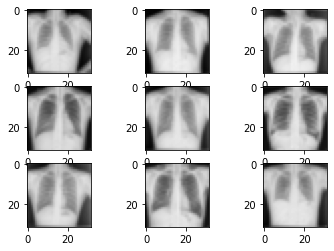

Train: X=(480, 32, 32, 1), y=(1, 480)
Test: X=(60, 32, 32, 1)


In [179]:
y_train = y_train.T #transpose y_train
y_val = y_val.T 
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i].squeeze(), cmap='gray', vmin=0, vmax=1)
# show the figure
plt.show()

# check the shape of training data and testing data
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s' % (X_test.shape, ))

## 7.2 mini-batch gradient descent

In [180]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape !!!!!!!!!!!(number of examples ,input size)!!!!!!!!!!!
    Y -- true "label" vector, of shape (number of classes, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]  # number of training examples
    mini_batches = []

    # GRADED CODE: Binary classification
    ### START CODE HERE ###
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[:,permutation]
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        # (approx. 2 lines)
        mini_batch_X = shuffled_X[k*inc:(k+1)*inc,:]
        mini_batch_Y = shuffled_Y[:,k*inc:(k+1)*inc]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        #(approx. 2 lines)
        mini_batch_X = shuffled_X[-inc:,:]
        mini_batch_Y = shuffled_Y[:,-inc:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    return mini_batches

    ### END CODE HERE ###

## 7.3 Start training

epoch:  0
Cost after iteration 0: 0.661984
epoch:  1
Cost after iteration 1: 0.705088
epoch:  2
Cost after iteration 2: 0.623702
epoch:  3
Cost after iteration 3: 0.534718
epoch:  4
Cost after iteration 4: 0.463160
epoch:  5
Cost after iteration 5: 0.598676
epoch:  6
Cost after iteration 6: 0.728414
epoch:  7
Cost after iteration 7: 0.404985
epoch:  8
Cost after iteration 8: 0.519487
epoch:  9
Cost after iteration 9: 0.470242
epoch:  10
Cost after iteration 10: 0.418391
epoch:  11
Cost after iteration 11: 0.765141
epoch:  12
Cost after iteration 12: 0.382587
epoch:  13
Cost after iteration 13: 0.582302
epoch:  14
Cost after iteration 14: 0.526801
epoch:  15
Cost after iteration 15: 0.815184
epoch:  16
Cost after iteration 16: 0.286377
epoch:  17
Cost after iteration 17: 0.306438
epoch:  18
Cost after iteration 18: 0.634552
epoch:  19
Cost after iteration 19: 0.379912


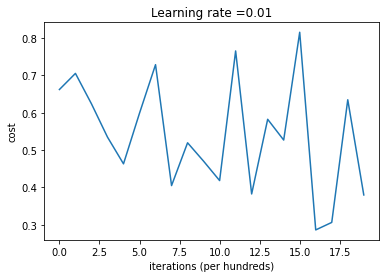

Accuracy: 0.7666666666666666
Accuracy: 0.7666666666666666


In [181]:
# GRADED CODE: Binary classification
### START CODE HERE ###
learning_rate = 0.01
num_iterations = 20
batch_size = 16
print_cost = True
classes = 2
costs = []   # keep track of cost


# build the model
model=Model()
model.add(Conv(filter_size=3, input_channel=1, output_channel=16, pad=0, stride=2))
model.add(Activation("relu"))
model.add(MaxPool(filter_size=2, stride=2))
model.add(Conv(filter_size=3, input_channel=16, output_channel=16, pad=0, stride=2))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(144, 32))
model.add(Activation("relu"))
model.add(Dense(32, 1))
model.add(Activation("sigmoid"))

# Loop (gradient descent)
for i in range(0, num_iterations):
    print("epoch: ",i)
    mini_batches = random_mini_batches(X_train, y_train, batch_size)
    j=0
    for batch in mini_batches:
        x_batch, y_batch = batch

        # forward
        AL = model.forward(x_batch)

        # compute cost
        if classes == 2:
            cost = compute_BCE_cost(AL, y_batch)
        else:
            cost = None

        # backward
        dA_prev = model.backward(AL,y_batch)

        # update
        model.update(learning_rate)
    
    print ("Cost after iteration %i: %f" %(i, cost))
    costs.append(cost)
### END CODE HERE ###
            
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()
ACCU1 = predict(X_train, y_train, model, 2)
accu = predict(X_val,y_val,model,2)

In [182]:
#accu = predict(X_val,y_val,model,2)
pred_test = predict(X_test, None, model, 2)
output["basic_pred_test"] = pred_test[0].astype(int)

basic_model_layers = []
basic_model_parameters = []
for layer in model.layers:
    basic_model_layers.append(layer.name)
    if(layer.name=="conv" or layer.name=="dense" or layer.name=="maxpool"):
        basic_model_parameters.append(layer.parameters)
output["basic_model_layers"] = basic_model_layers
output["basic_model_parameters"] = basic_model_parameters

# 8. Advanced implementation
In this part, you will practice how to build a model by **Tensorflow**, and you finally can use GPU to accelerate the training process☺️. You can import any packages in the advanced part.

**Exercise**: Implement a binary classifier by Tensorflow. You will get 15% if your prediction achieves accuracy greater than 0.7 in testing data. The rest 10% will be graded by your rank.

Except you have to build the model by Tensorflow, there is no limitation in this part. You can try different model architectures, optimization parametes and image augmentation methods to get good performance.



In [183]:
# import some tensorflow packages to help you build the model

import tensorflow as tf
from tensorflow.keras import layers, models
import keras
# import other packages here

In [184]:
# GRADED CODE: Advanced implementation
### Data preprocess & augmentation ###
y_train = y_train.T
y_val = y_val.T
#You may have to adjust the shape of y_train

In [185]:
# GRADED CODE: Advanced implementation
model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))


# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer="Adam",
           loss=tf.keras.losses.binary_crossentropy,
           metrics=['accuracy'])

# --------------------------2.設置callbacks---------------------------
# 另外新增lr降低條件
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=3, mode='min', verbose=1,
                           min_lr=1e-5)

# --------------------------4.開始訓練模型-----------------------------   
# 訓練模型時，以Callbacks監控，呼叫reduce_lr調整Learning Rate值
history = model.fit(X_train, y_train,epochs=20,validation_data=(X_val, y_val),callbacks= (reduce_lr))

### Start training ###

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_49 (Flatten)        (None, 8192)              0         
                                                                 
 dense_136 (Dense)           (None, 128)               1048704   
                                                                 
 dense_137 (Dense)           (None, 128)               16512     
                                                                 
 dense_138 (Dense)           (None, 128)               16512     
                                                     

In [186]:
# plt.plot([0.7124,0.6554,0.5206,0.4817,0.4563,0.4441,0.4284,0.3938,0.4238,0.4027,
#          0.4046,0.4018,0.3754,0.3633,0.3622,0.3478,0.3425,0.3352,0.3599,0.3580,0.3337,0.3270])
# plt.ylabel('cost')
# plt.xlabel('iterations (per hundreds)')
# plt.title("Learning rate =" + str(learning_rate))
# plt.show()

pred_test = model.predict(X_test)

#pred_test = np.argmax(pred_test, axis = 1)
for i in range(pred_test.shape[0]):
  if(pred_test[i] > 0.5):
    pred_test[i] = 1
  else:
    pred_test[i] = 0
pred_test = pred_test.flatten()
print(pred_test)
output["advanced_pred_test"] = pred_test

2/2 [==============================] - 0s 5ms/step
[1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.]


# Submit prediction

In [187]:
# sanity check


assert(list(output.keys()) == ['conv_initialization', 'zero_padding', 'conv_single_step', 'conv_forward_1', 'conv_forward_2', 'conv_forward_3', 'conv_update_1', 'conv_update_2', 'maxpool_forward', 'flatten_forward', 'flatten_backward', 'model_1', 'model_2', 'model_3', 'model_4', 'basic_pred_test', 'basic_model_layers', 'basic_model_parameters', 'advanced_pred_test'])

In [188]:
np.save("hw4_output.npy", output)

In [189]:
# sanity check
submit = np.load("hw4_output.npy", allow_pickle=True).item()
for key, value in submit.items():
    print(str(key) + "： " + str(type(value)))

conv_initialization： <class 'numpy.ndarray'>
zero_padding： <class 'numpy.ndarray'>
conv_single_step： <class 'numpy.float64'>
conv_forward_1： <class 'numpy.float64'>
conv_forward_2： <class 'numpy.ndarray'>
conv_forward_3： <class 'numpy.ndarray'>
conv_update_1： <class 'numpy.ndarray'>
conv_update_2： <class 'numpy.ndarray'>
maxpool_forward： <class 'numpy.ndarray'>
flatten_forward： <class 'numpy.ndarray'>
flatten_backward： <class 'numpy.ndarray'>
model_1： <class 'numpy.ndarray'>
model_2： <class 'numpy.ndarray'>
model_3： <class 'numpy.ndarray'>
model_4： <class 'numpy.ndarray'>
basic_pred_test： <class 'numpy.ndarray'>
basic_model_layers： <class 'list'>
basic_model_parameters： <class 'list'>
advanced_pred_test： <class 'numpy.ndarray'>


Expected output:<br>
<small>
conv_initialization： <class 'numpy.ndarray'> <br>
zero_padding： <class 'numpy.ndarray'> <br>
conv_single_step： <class 'numpy.float64'> <br>
conv_forward_1： <class 'numpy.float64'> <br>
conv_forward_2： <class 'numpy.ndarray'> <br>
conv_forward_3： <class 'numpy.ndarray'> <br>
conv_update_1： <class 'numpy.ndarray'> <br>
conv_update_2： <class 'numpy.ndarray'> <br>
maxpool_forward： <class 'numpy.ndarray'> <br>
flatten_forward： <class 'numpy.ndarray'> <br>
flatten_backward： <class 'numpy.ndarray'> <br>
model_1： <class 'numpy.ndarray'> <br>
model_2： <class 'numpy.ndarray'> <br>
model_3： <class 'numpy.ndarray'> <br>
model_4： <class 'numpy.ndarray'> <br>
basic_pred_test： <class 'numpy.ndarray'> <br>
basic_model_layers： <class 'list'> <br>
basic_model_parameters： <class 'list'> <br>
advanced_pred_test： <class 'numpy.ndarray'> <br>
</small>